Number of images in HLS Sentinel (raw): 1664
Number of images in HLS Landsat (raw): 1805
Number of images in HLS Sentinel (renamed): 1664
Number of images in HLS Landsat (renamed): 1805
Number of images in Landsat 7 (raw): 562
Number of images in Landsat 7 (after scaling & renaming): 562
Number of images in Landsat 7 (after cloud masking): 562
Number of joined images (Landsat 7 vs. HLS Sentinel): 116
Number of combined images (Landsat 7 vs. HLS Sentinel): 116
Number of valid combined images (Landsat 7 vs. HLS Sentinel): 8
Number of joined images (Landsat 7 vs. HLS Landsat): 64
Number of combined images (Landsat 7 vs. HLS Landsat): 64
Number of valid combined images (Landsat 7 vs. HLS Landsat): 12

Common dates for Landsat 7 vs. HLS Sentinel:
2017-06-22 10:40:21
2017-11-29 10:44:01
2023-07-11 10:36:31
2017-04-03 10:40:21
2017-06-22 10:40:21
2017-11-29 10:44:01
2020-04-27 10:40:31
2023-07-11 10:36:31

Common dates for Landsat 7 vs. HLS Landsat:
2022-02-28 10:27:42
2022-03-09 10:21:31
202

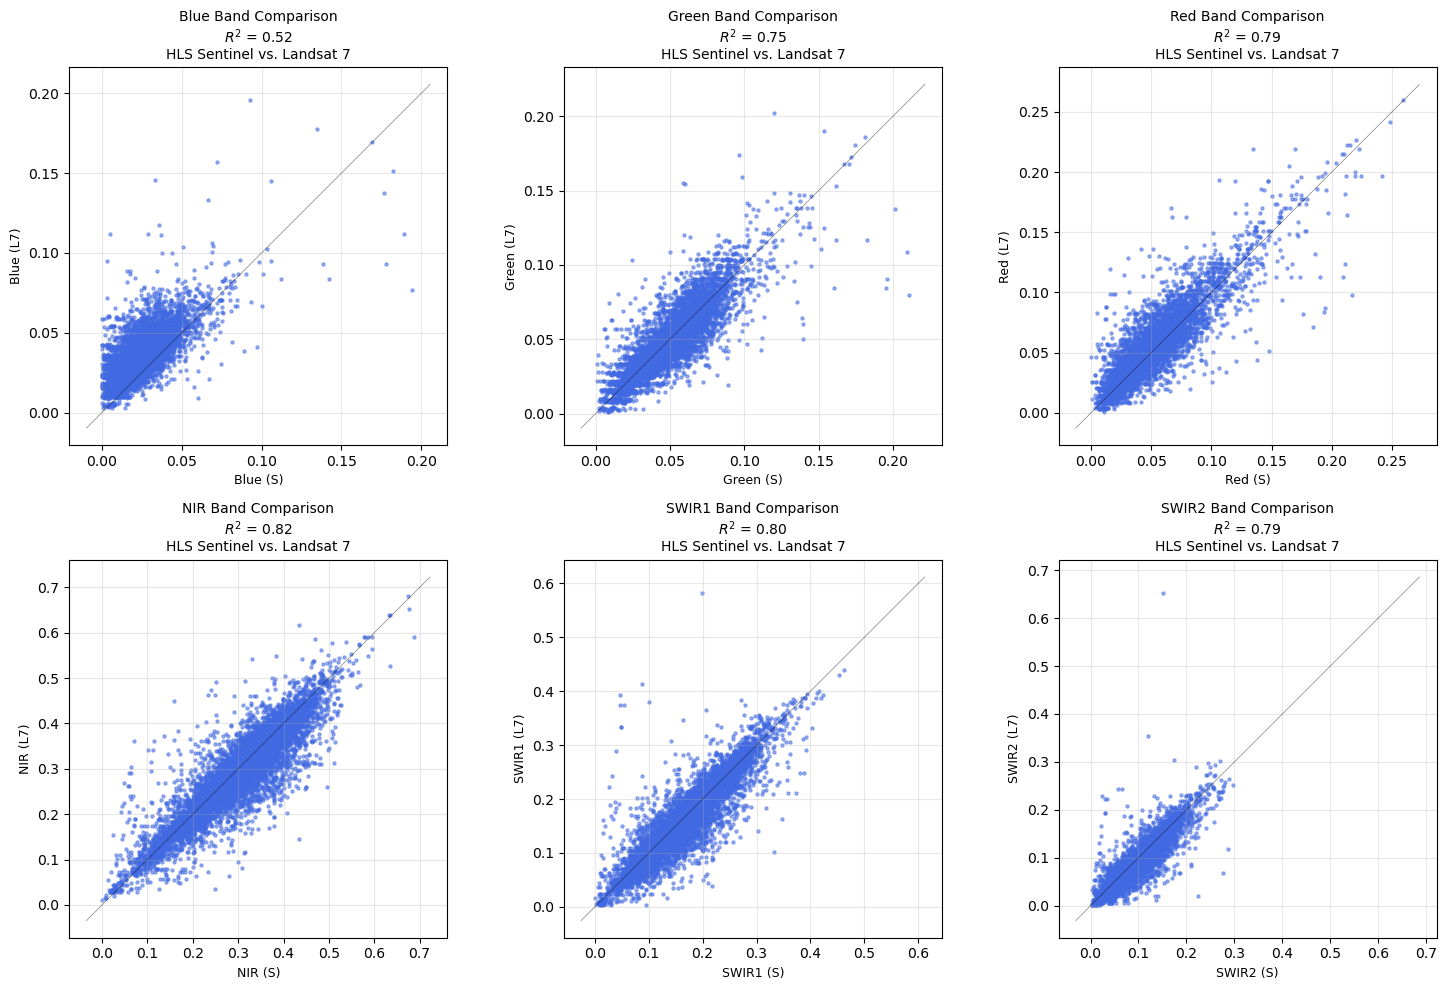

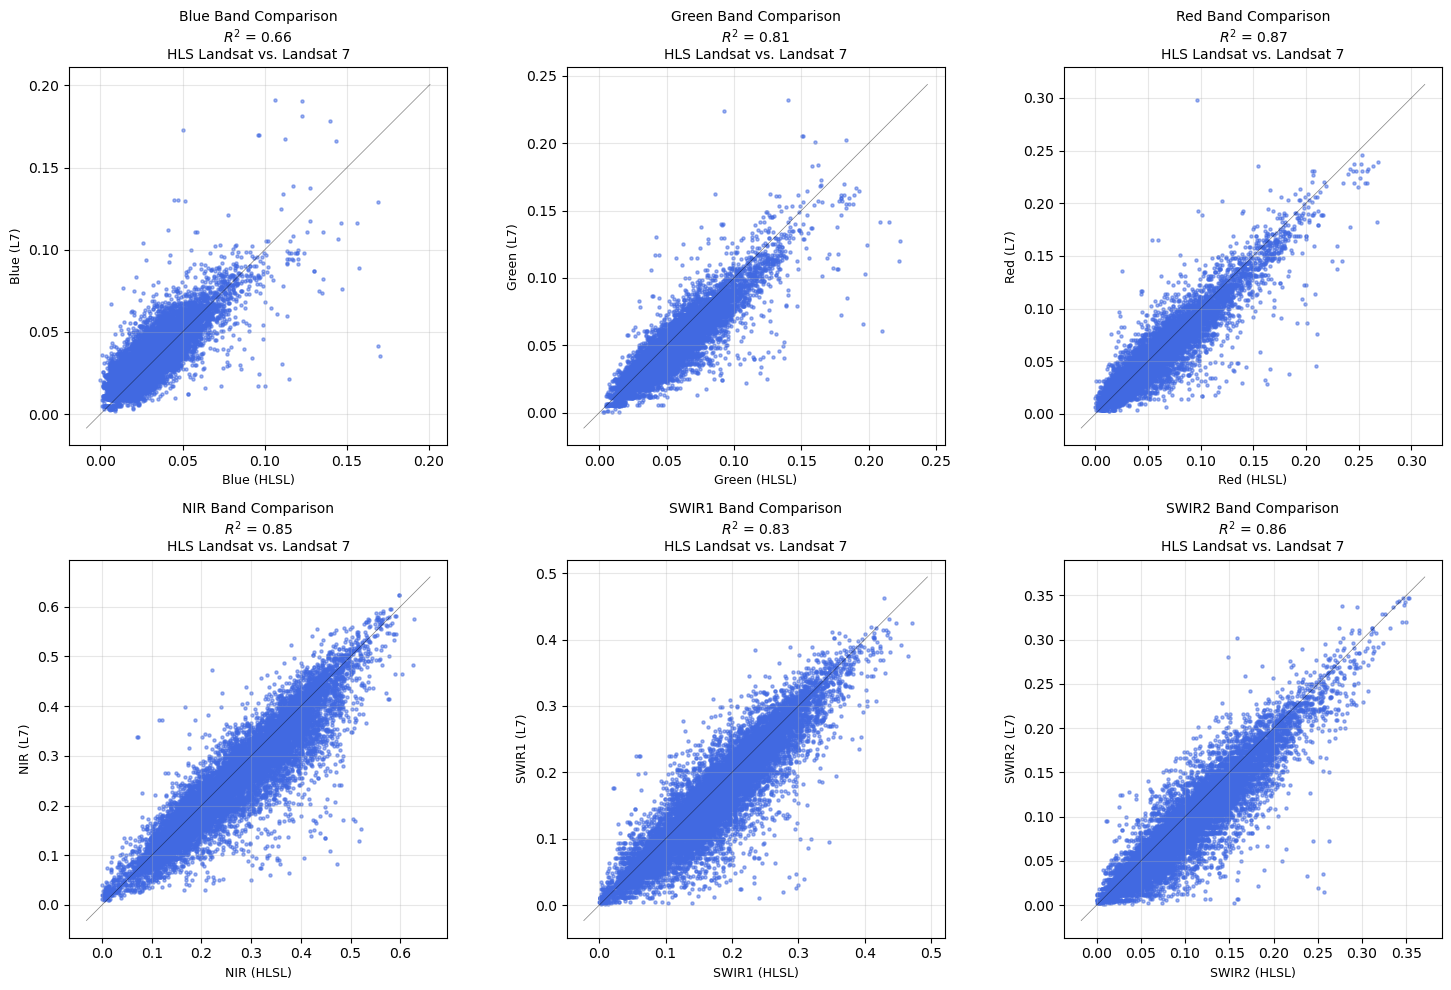

In [10]:
import ee
import geopandas as gpd
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =============================================================================
# 0. Authenticate and initialize Earth Engine
# =============================================================================
# ee.Authenticate()
ee.Initialize()

# =============================================================================
# 1. Load your AOI from a shapefile
# =============================================================================
shp_path = r"C:\Users\konst\Documents\Hiwi\mw3\drought_indicies\data\Untersuchungsgebiete\002a_Sen1-Subset_Eifel.shp"
gdf = gpd.read_file(shp_path)
geojson = gdf.to_json()
aoi = ee.Geometry(json.loads(geojson)['features'][0]['geometry'])

# =============================================================================
# 2. Define date range and cloud mask function for HLS data
# =============================================================================
start_date = '2013-01-01'
end_date   = '2025-01-31'

def mask_clouds(image):
    fmask = image.select('Fmask')
    cloud_bit = fmask.rightShift(1).bitwiseAnd(1)
    shadow_bit = fmask.rightShift(3).bitwiseAnd(1)
    mask = cloud_bit.eq(0).And(shadow_bit.eq(0))
    return image.updateMask(mask)

# =============================================================================
# 3. Load and filter the two HLS collections (Sentinel- and Landsat–based)
# =============================================================================
# HLS Sentinel-based
hlss30 = (ee.ImageCollection('NASA/HLS/HLSS30/v002')
          .filterBounds(aoi)
          .filterDate(start_date, end_date)
          .map(mask_clouds))
print("Number of images in HLS Sentinel (raw):", hlss30.size().getInfo())

# HLS Landsat-based
hlsl30 = (ee.ImageCollection('NASA/HLS/HLSL30/v002')
          .filterBounds(aoi)
          .filterDate(start_date, end_date)
          .map(mask_clouds))
print("Number of images in HLS Landsat (raw):", hlsl30.size().getInfo())

# Rename bands for consistency
hlss30_renamed = hlss30.map(lambda img: img.select(
    ['B2', 'B3', 'B4', 'B8A', 'B11', 'B12', 'B10', 'Fmask'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Cirrus', 'Fmask']
))
print("Number of images in HLS Sentinel (renamed):", hlss30_renamed.size().getInfo())

hlsl30_renamed = hlsl30.map(lambda img: img.select(
    ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9', 'Fmask'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'Cirrus', 'Fmask']
))
print("Number of images in HLS Landsat (renamed):", hlsl30_renamed.size().getInfo())

# (Note: The original code joined hlss30_renamed and hlsl30_renamed, but here we keep them
# for further comparisons with Landsat 7.)

# =============================================================================
# 4. Load and process Landsat 7 data
# =============================================================================
# Here we use a longer time range (from 2000) but note that the join
# will only return pairs with a matching date in the HLS collections.
landsat7 = (ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
          .filterBounds(aoi)
          .filterDate('2000-01-01', end_date))
print("Number of images in Landsat 7 (raw):", landsat7.size().getInfo())

def apply_scale_factors(image):
    """
    Applies scaling to Landsat 7 optical and thermal bands.
    
    Optical bands: multiply by 0.0000275 and add -0.2.
    Thermal band (ST_B6): multiply by 0.00341802 and add 149.0.
    
    The function replaces the original bands with the scaled values.
    """
    # Select all bands whose names match the pattern 'SR_B.' (i.e., optical bands)
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    # Process the thermal band (ST_B6)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(149.0)
    # Add the scaled bands back to the image, overwriting the originals.
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True)

landsat7_scaled = landsat7.map(apply_scale_factors)

landsat7_renamed = landsat7_scaled.map(lambda img: img.select(
    ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL'],
    ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'QA_PIXEL']
))
print("Number of images in Landsat 7 (after scaling & renaming):", landsat7_renamed.size().getInfo())

def mask_clouds_l7(image):
    # Bits 0 (Fill), 1 (Dilated Cloud), 3 (Cloud), 4 (Cloud Shadow)
    cloud_shadow_bitmask = (1 << 0) | (1 << 1) | (1 << 3) | (1 << 4)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloud_shadow_bitmask).eq(0)
    return image.updateMask(mask)

landsat7_masked = landsat7_renamed.map(mask_clouds_l7)
print("Number of images in Landsat 7 (after cloud masking):", landsat7_masked.size().getInfo())

# =============================================================================
# 5. Define a 6-hour tolerance for joining by acquisition time
# =============================================================================
six_hours_millis = 1000 * 60 * 60 * 6  # 6 hours in milliseconds
dateFilter = ee.Filter.maxDifference(
    difference=six_hours_millis,
    leftField='system:time_start',
    rightField='system:time_start'
)

# =============================================================================
# 6. Create Joined Collections
# =============================================================================

# ----- (A) Landsat 7 vs. HLS Sentinel -----
join_l7_sentinel = ee.Join.inner()
joined_l7_sentinel = join_l7_sentinel.apply(hlss30_renamed, landsat7_masked, dateFilter)
print("Number of joined images (Landsat 7 vs. HLS Sentinel):", joined_l7_sentinel.size().getInfo())

def merge_images_l7_sentinel(joined_feature):
    # Get the pair of images
    hls_sentinel_img = ee.Image(joined_feature.get('primary'))
    landsat7_img = ee.Image(joined_feature.get('secondary'))
    # Rename bands so that HLS Sentinel bands get a _S suffix...
    hls_sentinel_renamed = hls_sentinel_img.select(
        ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'],
        ['Blue_S', 'Green_S', 'Red_S', 'NIR_S', 'SWIR1_S', 'SWIR2_S']
    )
    # ...and Landsat 7 bands get a _L7 suffix.
    landsat7_renamed = landsat7_img.select(
        ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'],
        ['Blue_L7', 'Green_L7', 'Red_L7', 'NIR_L7', 'SWIR1_L7', 'SWIR2_L7']
    )
    combined = hls_sentinel_renamed.addBands(landsat7_renamed)
    return combined.set('system:time_start', hls_sentinel_img.get('system:time_start'))

combined_l7_sentinel = joined_l7_sentinel.map(merge_images_l7_sentinel)
print("Number of combined images (Landsat 7 vs. HLS Sentinel):", combined_l7_sentinel.size().getInfo())

def calc_valid_pct_l7_sentinel(image):
    image = ee.Image(image)
    blue_l7 = image.select('Blue_L7')
    blue_s= image.select('Blue_S')
    
    valid_mask = blue_l7.mask().And(blue_s.mask()).rename('mask')
    valid_percent_dict = valid_mask.reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=aoi,
         scale=30,
         maxPixels=1e9
    )
    valid_percent = ee.Number(valid_percent_dict.get('mask')).multiply(100)
    return image.set('valid_percent', valid_percent)

combined_l7_sentinel = combined_l7_sentinel.map(calc_valid_pct_l7_sentinel)
combined_l7_sentinel = combined_l7_sentinel.filter(ee.Filter.gte('valid_percent', 30))
print("Number of valid combined images (Landsat 7 vs. HLS Sentinel):", combined_l7_sentinel.size().getInfo())

# ----- (B) Landsat 7 vs. HLS Landsat -----
join_l7_hlslandsat = ee.Join.inner()
joined_l7_hlslandsat = join_l7_hlslandsat.apply(hlsl30_renamed, landsat7_masked, dateFilter)
print("Number of joined images (Landsat 7 vs. HLS Landsat):", joined_l7_hlslandsat.size().getInfo())

def merge_images_l7_hlslandsat(joined_feature):
    hls_landsat_img = ee.Image(joined_feature.get('primary'))
    landsat7_img = ee.Image(joined_feature.get('secondary'))
    # Rename HLS Landsat bands with a _HLSL suffix...
    hls_landsat_renamed = hls_landsat_img.select(
        ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'],
        ['Blue_HLSL', 'Green_HLSL', 'Red_HLSL', 'NIR_HLSL', 'SWIR1_HLSL', 'SWIR2_HLSL']
    )
    # ...and Landsat 7 bands with a _L7 suffix.
    landsat7_renamed = landsat7_img.select(
        ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'],
        ['Blue_L7', 'Green_L7', 'Red_L7', 'NIR_L7', 'SWIR1_L7', 'SWIR2_L7']
    )
    combined = hls_landsat_renamed.addBands(landsat7_renamed)
    return combined.set('system:time_start', hls_landsat_img.get('system:time_start'))

combined_l7_hlslandsat = joined_l7_hlslandsat.map(merge_images_l7_hlslandsat)
print("Number of combined images (Landsat 7 vs. HLS Landsat):", combined_l7_hlslandsat.size().getInfo())

def calc_valid_pct_l7_hlslandsat(image):
    image = ee.Image(image)
    blue_l7 = image.select('Blue_L7')
    blue_hlsl = image.select('Blue_HLSL')
    
    valid_mask = blue_l7.mask().And(blue_hlsl.mask()).rename('mask')
    valid_percent_dict = valid_mask.reduceRegion(
         reducer=ee.Reducer.mean(),
         geometry=aoi,
         scale=30,
         maxPixels=1e9
    )
    valid_percent = ee.Number(valid_percent_dict.get('mask')).multiply(100)
    return image.set('valid_percent', valid_percent)

combined_l7_hlslandsat = combined_l7_hlslandsat.map(calc_valid_pct_l7_hlslandsat)
combined_l7_hlslandsat = combined_l7_hlslandsat.filter(ee.Filter.gte('valid_percent', 30))
print("Number of valid combined images (Landsat 7 vs. HLS Landsat):", combined_l7_hlslandsat.size().getInfo())

# ---------------------------------------
# 1. Print common dates for Landsat 7 vs. HLS Sentinel
# ---------------------------------------
size_sen = combined_l7_sentinel.size().getInfo()
if size_sen > 0:
    sentinel_list = combined_l7_sentinel.toList(size_sen)
    print("\nCommon dates for Landsat 7 vs. HLS Sentinel:")
    for i in range(size_sen):
        image = ee.Image(sentinel_list.get(i))
        epoch_time = image.get('system:time_start').getInfo()  # milliseconds since epoch
        date_str = pd.to_datetime(epoch_time, unit='ms').strftime('%Y-%m-%d %H:%M:%S')
        print(date_str)
else:
    print("\nNo common images for Landsat 7 vs. HLS Sentinel.")

# ---------------------------------------
# 2. Print common dates for Landsat 7 vs. HLS Landsat
# ---------------------------------------
size_hlsl = combined_l7_hlslandsat.size().getInfo()
if size_hlsl > 0:
    hlslandsat_list = combined_l7_hlslandsat.toList(size_hlsl)
    print("\nCommon dates for Landsat 7 vs. HLS Landsat:")
    for i in range(size_hlsl):
        image = ee.Image(hlslandsat_list.get(i))
        epoch_time = image.get('system:time_start').getInfo()
        date_str = pd.to_datetime(epoch_time, unit='ms').strftime('%Y-%m-%d %H:%M:%S')
        print(date_str)
else:
    print("\nNo common images for Landsat 7 vs. HLS Landsat.")

# =============================================================================
# 7. Sample data from each joined collection and build pandas DataFrames
# =============================================================================
def sample_collection(image_collection, band_names, num_pixels=2000):
    """Samples each image in an EE collection and returns a list of dictionaries."""
    coll_size = image_collection.size().getInfo()
    print("Number of images to sample from:", coll_size)
    image_list = image_collection.toList(coll_size)
    data = {band: [] for band in band_names}
    
    for i in range(coll_size):
        image = ee.Image(image_list.get(i))
        samples = image.sample(
            region=aoi,
            scale=30,
            numPixels=num_pixels,
            seed=42
        )
        samples_info = samples.getInfo()
        for feat in samples_info['features']:
            props = feat['properties']
            for band in band_names:
                data[band].append(props.get(band))
        print(f"Processed joined image {i+1}/{coll_size}")
    return pd.DataFrame(data)

# For Landsat 7 vs. HLS Sentinel, our bands are:
bands_l7_sentinel = ['Blue_S', 'Blue_L7', 
                     'Green_S', 'Green_L7', 
                     'Red_S', 'Red_L7', 
                     'NIR_S', 'NIR_L7', 
                     'SWIR1_S', 'SWIR1_L7', 
                     'SWIR2_S', 'SWIR2_L7']

df_l7_sentinel = sample_collection(combined_l7_sentinel, bands_l7_sentinel)
print("Total samples (Landsat 7 vs. HLS Sentinel):", len(df_l7_sentinel))

# Remove rows with any negative values
df_l7_sentinel = df_l7_sentinel[(df_l7_sentinel >= 0).all(axis=1)]
print("Total samples after removing negative values (Landsat 7 vs. HLS Sentinel):", len(df_l7_sentinel))


# For Landsat 7 vs. HLS Landsat, our bands are:
bands_l7_hlslandsat = ['Blue_HLSL', 'Blue_L7', 
                       'Green_HLSL', 'Green_L7', 
                       'Red_HLSL', 'Red_L7', 
                       'NIR_HLSL', 'NIR_L7', 
                       'SWIR1_HLSL', 'SWIR1_L7', 
                       'SWIR2_HLSL', 'SWIR2_L7']

df_l7_hlslandsat = sample_collection(combined_l7_hlslandsat, bands_l7_hlslandsat)
print("Total samples (Landsat 7 vs. HLS Landsat):", len(df_l7_hlslandsat))

# Remove rows with any negative values
df_l7_hlslandsat = df_l7_hlslandsat[(df_l7_hlslandsat >= 0).all(axis=1)]
print("Total samples after removing negative values (Landsat 7 vs. HLS Landsat):", len(df_l7_hlslandsat))

# =============================================================================
# 8. Plot scatter plots for each comparison
# =============================================================================
def plot_scatter(df, sensor1_prefix, sensor2_prefix, title_suffix):
    """
    Create scatter plots comparing sensor1 and sensor2 bands.
    sensor1_prefix: prefix for the first sensor (e.g., 'Blue_S' or 'Blue_HLSL')
    sensor2_prefix: prefix for the second sensor (e.g., 'Blue_L7')
    title_suffix: string to include in the title (e.g., 'HLS Sentinel vs. Landsat 7')
    """
    bands = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
    for idx, band in enumerate(bands):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        sensor1_band = f"{band}_{sensor1_prefix}"
        sensor2_band = f"{band}_{sensor2_prefix}"
        
        # Calculate correlation coefficient and R^2
        r = df[sensor1_band].corr(df[sensor2_band])
        r2 = r ** 2
        
        ax.scatter(df[sensor1_band], df[sensor2_band], s=5, alpha=0.5, color='royalblue')
        ax.set_xlabel(f'{band} ({sensor1_prefix})', fontsize=9)
        ax.set_ylabel(f'{band} ({sensor2_prefix})', fontsize=9)
        ax.set_title(f'{band} Band Comparison\n$R^2$ = {r2:.2f}\n{title_suffix}', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Add a diagonal 1:1 line
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
        ax.plot(lims, lims, 'k-', alpha=0.5, lw=0.5)
        ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# --- Plot for Landsat 7 vs. HLS Sentinel ---
plot_scatter(df_l7_sentinel, sensor1_prefix='S', sensor2_prefix='L7', 
             title_suffix='HLS Sentinel vs. Landsat 7')

# --- Plot for Landsat 7 vs. HLS Landsat ---
plot_scatter(df_l7_hlslandsat, sensor1_prefix='HLSL', sensor2_prefix='L7', 
             title_suffix='HLS Landsat vs. Landsat 7')
